In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from lib.generators.LFR import LFR

In [2]:
def lfr_reconstruction_and_classification(mu, seed, n=1000, t1=3, t2=1.1):
    generator = LFR(n=n, t1=t1, t2=t2, m=mu, seed=seed)
    feature_names = generator.feature_names

    link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

    model =\
        RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)\
        .fit(link_prediction_train[feature_names], link_prediction_train['goal'])

    prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
    prob = pd.Series(prob, name='prob')
    link_proba = link_prediction_train.join(prob)

    link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)

    train_median_error = link_proba['abs_error'].median()

    link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)

    model_2 =\
        RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)\
        .fit(link_proba[feature_names], link_proba['quality_label'])

    pred = model_2.predict(classifier_test[feature_names])
    pred = pd.Series(pred, name='predicted_quality_label')

    proba = model.predict_proba(classifier_test[feature_names])[:,1]
    proba = pd.Series(proba, name='prediction_probability')

    classifier_test = classifier_test.join(proba)
    classifier_test = classifier_test.join(pred)

    classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
    test_median_error = classifier_test['true_abs_error'].median()

    classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)

    return\
        metrics.roc_auc_score(link_prediction_test['goal'], model.predict_proba(link_prediction_test[feature_names])[:, 1]),\
        metrics.roc_auc_score(classifier_test['true_quality_label'], model_2.predict_proba(classifier_test[feature_names])[:,1])

In [3]:
# hyperparameters

MU = [0.1, 0.33, 0.5, 0.66, 1]         # mu
seed = random.randint(1, 1000)         # random seed

In [4]:
rows_list = []

for mu in MU:
    print(f'For MU={mu} calculating:')
    p_auc, c_auc = lfr_reconstruction_and_classification(mu, seed, n=5000)
    rows_list.append({'mu': mu, 'reconstruction': p_auc, 'classification': c_auc})
    print()

df = pd.DataFrame(rows_list, columns=['mu', 'reconstruction', 'classification'])
df

For MU=0.1 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating

For MU=0.33 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating

For MU=0.5 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating

For MU=0.66 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating

For MU=1 calculating:
Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating



,mu,reconstruction,classification
0,0.10,0.732091,0.999823
1,0.33,0.722298,0.999477
2,0.50,0.688551,0.999548
3,0.66,0.692217,0.999604
4,1.00,0.705058,0.999494


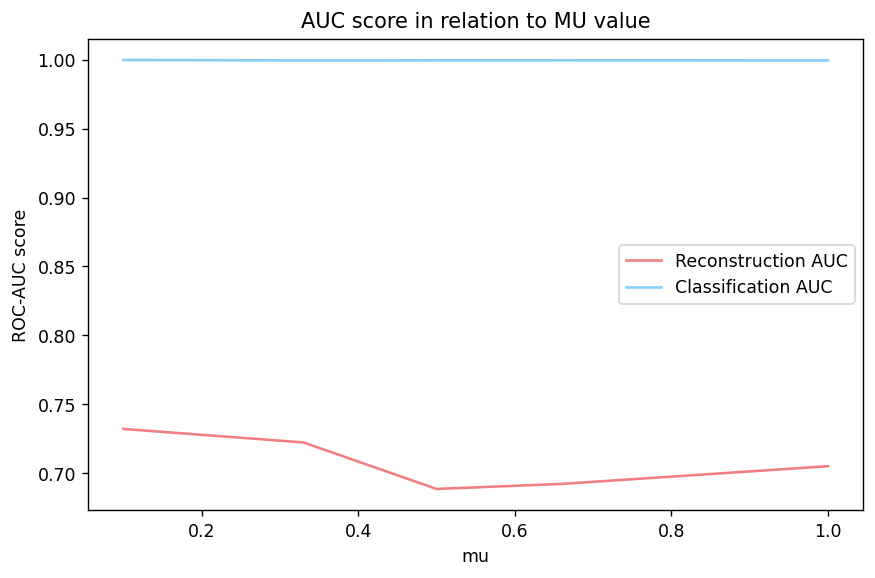

In [5]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

fig, ax = plt.subplots()

sn.lineplot( 
    x=df['mu'], 
    y=df['reconstruction'], 
    label='Reconstruction AUC',
    ax=ax, 
    color='lightcoral'
)

sn.lineplot( 
    x=df['mu'], 
    y=df['classification'], 
    label='Classification AUC',
    ax=ax, 
    color='lightskyblue'
)

ax.set_title("AUC score in relation to MU value")
ax.set_ylabel("ROC-AUC score")
ax.legend()